In [ ]:
import time
import datetime
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [ ]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
ticker='DIS'
period1 = int(time.mktime(datetime.datetime(2015, 1, 1, 0, 0).timetuple()))
period2 = int(time.mktime(datetime.datetime.now().timetuple()))
interval = '1d' # 1d, 1m
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
df_dis = pd.read_csv(query_string)

In [ ]:
df_dis['symbol']='DIS'
df_dis
#df_dis.to_csv('DIS.csv')

In [ ]:
#setting index as date
df_dis['Date'] = pd.to_datetime(df_dis.Date,format='%Y-%m-%d')
df_dis.index = df_dis['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df_dis['Close'], label='Precio de Cierre Historico')

In [ ]:
#creating dataframe with date and the target variable
data = df_dis.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df_dis)),columns=['Date', 'Close'])

for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

In [ ]:
new_data.head()

In [ ]:
# new_data.iloc[951:955]
new_data.iloc[250:255]
# new_data.loc[new_data.dates=='2015-09-24 00:00:00']

In [ ]:
#splitting into train and validation
train = new_data[:1551]
valid = new_data[1556:] 

In [ ]:
new_data.shape, train.shape, valid.shape

In [ ]:
train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()

In [ ]:
#make predictions
preds = []
for i in range(0,226):
    a = train['Close'][len(train)-226+i:].sum() + sum(preds)
    b = a/226
    preds.append(b)

In [ ]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
rms

In [ ]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Original Data','Valid Data', 'Predicted Data'])
plt.show()

In [ ]:
#### Cambio

### Auto ARIMA

In [ ]:
#pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
data = df_dis.sort_index(ascending=True, axis=0)

train = data[:1551]
valid = data[1556:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True) # Hablar de cada parametro
model.fit(training)
print('ahhhh')
forecast = model.predict(n_periods=226) # hablar de modelo
print('asdasd')
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction']) # rxplicar que es lo que muestra
print('asdasd222222')

In [ ]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2))) # Que es esto
rms

In [ ]:
#plot
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction']) # Explicar grafico

In [ ]:
###### Cambio
plt.show()

### Long Short Term Memory (LSTM)

In [ ]:
#creating dataframe
data = df_dis.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df_dis)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1551,:]
valid = dataset[1556:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

In [ ]:
#for plotting
train = new_data[:1551]
valid = new_data[1556:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [ ]:
#### Cambio

### Decision Tree Regression and Linear Regression # Se dividen 

In [ ]:
ticker='DIS'
period1 = int(time.mktime(datetime.datetime(2015, 1, 1, 0, 0).timetuple()))
period2 = int(time.mktime(datetime.datetime.now().timetuple()))
interval = '1d' # 1d, 1m
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
df = pd.read_csv(query_string)

In [ ]:
df['symbol']='DIS'
df.index=pd.to_datetime(df['Date'])
df=df.drop(['Date'],axis='columns')
df
#df.to_csv('DIS.csv')

In [ ]:
df=df[['Close']]
df

In [ ]:
#Create a variable to predict 'x' days out the future
future_days=100
#Create a new column (target) shifted 'x' units/dayys up
df['Prediction']=df[['Close']].shift(-future_days)
df.tail(4)

In [ ]:
# Create the feature data set (x) and convert it to a numpy_array and remove the last 'x' rows/days
X= np.array(df.drop(['Prediction'],1))[:-future_days]
print(X)

In [ ]:
#Create the target data ser (y) it to a numpy array and get all of the taret values except the rows
y = np.array(df['Prediction'])[:-future_days]
print(y)

In [ ]:
#Split the data into 75% training and 25% testing 
x_train,x_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [ ]:
#Create the models
#Create the decision tree regressor model 
tree = DecisionTreeRegressor().fit(x_train,y_train)

#Create the linear regression model
lr = LinearRegression().fit(x_train,y_train)

In [ ]:
#Get the last 'x' rows of the futured data set
x_future = df.drop(['Prediction'],1)[:-future_days]
x_future = x_future.tail(future_days)
x_future = np.array(x_future)
x_future
# Show the model tree prediction
tree_prediction = tree.predict(x_future)

In [ ]:
# Show the model tree prediction
tree_prediction = tree.predict(x_future)
print(tree_prediction)
print()
# Show the model linear regression prediction
lr_prediction = lr.predict(x_future)
print(lr_prediction)

In [ ]:
rms=np.sqrt(np.mean(np.power((x_future-tree_prediction),2)))
rms

In [ ]:
# Visualize the data
predictions = tree_prediction

valid = df[X.shape[0]:]
valid['Predictions']=predictions
plt.figure(figsize=(16,8))
plt.title('Model Decision Tree')
plt.xlabel('Days')
plt.ylabel('Close Price USD($)')
plt.plot(df['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Original Data','Valid Data', 'Predicted Data'])
plt.show()

In [ ]:
rms=np.sqrt(np.mean(np.power((x_future-lr_prediction),2)))
rms

In [ ]:
# Visualize the data
predictions = lr_prediction

valid = df[X.shape[0]:]
valid['Predictions']=predictions
plt.figure(figsize=(16,8))
plt.title('Model Linear Regression')
plt.xlabel('Days')
plt.ylabel('Close Price USD($)')
plt.plot(df['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Original Data','Valid Data', 'Predicted Data'])
plt.show()

In [ ]:
import anvil.server
anvil.server.connect("CN2TMBDRW25CF7YM2ZZDMFQ5-2ESNL62FX4JIIFVL")

In [1]:
#servidor libreria
import anvil.server
import anvil.mpl_util

import time
import datetime
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error
from pmdarima.arima import auto_arima
#from fbprophet import Prophet
from functools import reduce
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
#setting figure size
from matplotlib.pylab import rcParams
#for normalizing data
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import classification_report

def make_plot1():
    #RMS
    ticker='DIS'
    period1 = int(time.mktime(datetime.datetime(2015, 1, 1, 0, 0).timetuple()))
    period2 = int(time.mktime(datetime.datetime.now().timetuple()))
    interval = '1d' # 1d, 1m
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    df_dis = pd.read_csv(query_string)
    df_dis['symbol']='DIS'
    df_dis
    #Create a variable to predict 'x' days out the future
    future_days=100
    #Create a new column (target) shifted 'x' units/dayys up
    df['Prediction']=df[['Close']].shift(-future_days)
    df.tail(4)
    # Create the feature data set (x) and convert it to a numpy_array and remove the last 'x' rows/days
    X= np.array(df.drop(['Prediction'],1))[:-future_days]
    #Create the target data ser (y) it to a numpy array and get all of the taret values except the rows
    y = np.array(df['Prediction'])[:-future_days]
    #----------
    #-------
    data = df_dis.sort_index(ascending=True, axis=0)
    new_data = pd.DataFrame(index=range(0,len(df_dis)),columns=['Date', 'Close'])

    for i in range(0,len(data)):
         new_data['Date'][i] = data['Date'][i]
         new_data['Close'][i] = data['Close'][i]
    #splitting into train and validation
    train = new_data[:1551]
    valid = new_data[1556:] 
    train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()
    #make predictions
    preds = []
    for i in range(0,226):
        a = train['Close'][len(train)-226+i:].sum() + sum(preds)
        b = a/226
        preds.append(b)
    #calculate rmse
    rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
    rms
    valid['Predictions'] = 0
    valid['Predictions'] = preds
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Original Data','Valid Data', 'Predicted Data'])
    
    #plt.show()

def make_plot2():
    #FORECAST ARIMA
    ticker='DIS'
    period1 = int(time.mktime(datetime.datetime(2015, 1, 1, 0, 0).timetuple()))
    period2 = int(time.mktime(datetime.datetime.now().timetuple()))
    interval = '1d' # 1d, 1m
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    df_dis_2 = pd.read_csv(query_string) 
    df_dis_2['symbol']='DIS'
    df_dis_2
    data = df_dis_2.sort_index(ascending=True, axis=0)
    train_2 = data[:1551]
    valid_2 = data[1556:]
    training_2 = train_2['Close']
    validation_2 = valid_2['Close']
    model_2 = auto_arima(training_2, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True) # Hablar de cada parametro
    model_2.fit(training_2)
    forecast = model_2.predict(n_periods=226) # hablar de modelo
    forecast = pd.DataFrame(forecast,index = valid_2.index,columns=['Prediction']) # rxplicar que es lo que muestra
    rms=np.sqrt(np.mean(np.power((np.array(valid_2['Close'])-np.array(forecast['Prediction'])),2))) # Que es esto
    rms
    #plot
    plt.figure(figsize=(16,8))
    plt.title('Model Arima')
    plt.plot(train_2['Close'])
    plt.plot(valid_2['Close'])
    plt.plot(forecast['Prediction']) # Explicar grafico
    plt.legend(['Original Data','Valid Data', 'Predicted Data'])
def make_plot3():
    #LSTM
    plt.show()
    ticker='DIS'
    period1 = int(time.mktime(datetime.datetime(2015, 1, 1, 0, 0).timetuple()))
    period2 = int(time.mktime(datetime.datetime.now().timetuple()))
    interval = '1d' # 1d, 1m
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    df_dis = pd.read_csv(query_string)
    df_dis['symbol']='DIS'
    df_dis
    #creating dataframe
    data = df_dis.sort_index(ascending=True, axis=0)
    new_data = pd.DataFrame(index=range(0,len(df_dis)),columns=['Date', 'Close'])
    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data['Close'][i]

    #setting index
    new_data.index = new_data.Date
    new_data.drop('Date', axis=1, inplace=True)

    #creating train and test sets
    dataset = new_data.values

    train = dataset[0:1551,:]
    valid = dataset[1556:,:]

    #converting dataset into x_train and y_train
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    x_train, y_train = [], []
    for i in range(60,len(train)):
        x_train.append(scaled_data[i-60:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

    #predicting 246 values, using past 60 from the train data
    inputs = new_data[len(new_data) - len(valid) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)

    X_test = []
    for i in range(60,inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    rms
    # Visualize the data
    predictions = closing_price
    #for plotting
    train = new_data[:1551]
    valid = new_data[1556:]
    valid['Predictions'] = predictions
    plt.figure(figsize=(16,8))
    plt.title('Model LSTM')
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.legend(['Original Data','Valid Data', 'Predicted Data'])
    
    
def make_plot4():
    #DECISION TREE
    #---------
    ticker='DIS'
    period1 = int(time.mktime(datetime.datetime(2015, 1, 1, 0, 0).timetuple()))
    period2 = int(time.mktime(datetime.datetime.now().timetuple()))
    interval = '1d' # 1d, 1m
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    df = pd.read_csv(query_string)
    df['symbol']='DIS'
    df.index=pd.to_datetime(df['Date'])
    df=df.drop(['Date'],axis='columns')
    df=df[['Close']]
    df
    #Create a variable to predict 'x' days out the future
    future_days=100
    #Create a new column (target) shifted 'x' units/dayys up
    df['Prediction']=df[['Close']].shift(-future_days)
    df.tail(4)
    # Create the feature data set (x) and convert it to a numpy_array and remove the last 'x' rows/days
    X= np.array(df.drop(['Prediction'],1))[:-future_days]
    #Create the target data ser (y) it to a numpy array and get all of the taret values except the rows
    y = np.array(df['Prediction'])[:-future_days]
    #Split the data into 75% training and 25% testing 
    x_train,x_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
    #Create the models
    #Create the decision tree regressor model 
    tree = DecisionTreeRegressor().fit(x_train,y_train)
    #Get the last 'x' rows of the futured data set
    x_future = df.drop(['Prediction'],1)[:-future_days]
    x_future = x_future.tail(future_days)
    x_future = np.array(x_future)
    # Show the model tree prediction
    tree_prediction = tree.predict(x_future)
    rms=np.sqrt(np.mean(np.power((x_future-tree_prediction),2)))
    rms
    # Visualize the data
    predictions = tree_prediction

    valid = df[X.shape[0]:]
    valid['Predictions']=predictions
    plt.figure(figsize=(16,8))
    plt.title('Model Decision Tree')
    plt.xlabel('Days')
    plt.ylabel('Close Price USD($)')
    plt.plot(df['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.legend(['Original Data','Valid Data', 'Predicted Data'])
    #plt.show()

def make_plot5():
    #regresion lineal
    #---------
    ticker='DIS'
    period1 = int(time.mktime(datetime.datetime(2015, 1, 1, 0, 0).timetuple()))
    period2 = int(time.mktime(datetime.datetime.now().timetuple()))
    interval = '1d' # 1d, 1m
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    df = pd.read_csv(query_string)
    df['symbol']='DIS'
    df.index=pd.to_datetime(df['Date'])
    df=df.drop(['Date'],axis='columns')
    df=df[['Close']]
    df
    #Create a variable to predict 'x' days out the future
    future_days=100
    #Create a new column (target) shifted 'x' units/dayys up
    df['Prediction']=df[['Close']].shift(-future_days)
    df.tail(4)
    # Create the feature data set (x) and convert it to a numpy_array and remove the last 'x' rows/days
    X= np.array(df.drop(['Prediction'],1))[:-future_days]
    #Create the target data ser (y) it to a numpy array and get all of the taret values except the rows
    y = np.array(df['Prediction'])[:-future_days]
    #Split the data into 75% training and 25% testing 
    x_train,x_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
    #Create the models
    #Create the linear regression model
    lr = LinearRegression().fit(x_train,y_train)
    #Get the last 'x' rows of the futured data set
    x_future = df.drop(['Prediction'],1)[:-future_days]
    x_future = x_future.tail(future_days)
    x_future = np.array(x_future)
    # Show the model linear regression prediction
    lr_prediction = lr.predict(x_future)
    #print(lr_prediction)
    rms=np.sqrt(np.mean(np.power((x_future-lr_prediction),2)))
    rms
    # Visualize the data
    predictions = lr_prediction

    valid = df[X.shape[0]:]
    valid['Predictions']=predictions
    plt.figure(figsize=(16,8))
    plt.title('Model Linear Regression')
    plt.xlabel('Days')
    plt.ylabel('Close Price USD($)')
    plt.plot(df['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.legend(['Original Data','Valid Data', 'Predicted Data'])
    #plt.show()

def make_plot6():
    #SVC
    ticker='DIS'
    period1 = int(time.mktime(datetime.datetime(2015, 1, 1, 0, 0).timetuple()))
    period2 = int(time.mktime(datetime.datetime.now().timetuple()))
    interval = '1d' # 1d, 1m
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    df_dis = pd.read_csv(query_string)
    df_dis['symbol']='DIS'
    df_dis
    # Se crean variables predictoras
    df_dis['Open-Close'] = df_dis.Open - df_dis.Close
    df_dis['High-Low'] = df_dis.High - df_dis.Low
    # Se guardan todas las variables predictoras en una variable X
    X = df_dis[['Open-Close', 'High-Low']]
    X.tail(4)
    y = np.where(df_dis['Close'].shift(-1) > df_dis['Close'], 1, 0)
    #Dividir los datos en 75 % de entrenamiento y 25 % de prueba
    x_train,x_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
    modelo = SVC().fit(x_train, y_train)
    y_predict = modelo.predict(x_test)
    print(classification_report(y_test,y_predict))
    prueba = [[1.160004 , 2.430001],[-0.110001, 1.050004]]
    df = pd.DataFrame(prueba, columns=['Open-Close', 'High-Low'])
    y_predict = modelo.predict(df)
    y_predict
    df_dis['Predicted_Signal'] = modelo.predict(X)
    df_dis['Predicted_Signal']
    # Calcular devoluciones diarias
    df_dis['Return'] = df_dis.Close.pct_change()
    df_dis['Return']
    # Calcular devoluciones estratégicas
    df_dis['Strategy_Return'] = df_dis.Return *df_dis.Predicted_Signal.shift(1)
    df_dis['Strategy_Return']
    # Calcular rendimientos acumulativos
    df_dis['Cum_Ret'] = df_dis['Return'].cumsum()
    # Plot estrategia de rendimientos acumulados
    df_dis['Cum_Strategy'] = df_dis['Strategy_Return'].cumsum()
    #Establecer el índice como fecha
    df_dis['Date'] = pd.to_datetime(df_dis.Date,format='%Y-%m-%d')
    df_dis.index = df_dis['Date']
    plt.plot(df_dis['Cum_Ret'],color='purple')
    plt.plot(df_dis['Cum_Strategy'],color='pink')
    plt.legend(['Rendimientos acumulativos','Estrategia de rendimientos acumulados'])
    plt.xlabel('Años')
    plt.ylabel('?')
    #plt.show()

def make_plot7():
    #SVR
    #---------
    ticker='DIS'
    period1 = int(time.mktime(datetime.datetime(2015, 1, 1, 0, 0).timetuple()))
    period2 = int(time.mktime(datetime.datetime.now().timetuple()))
    interval = '1d' # 1d, 1m
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    df = pd.read_csv(query_string)
    df['symbol']='DIS'
    df.index=pd.to_datetime(df['Date'])
    df=df.drop(['Date'],axis='columns')
    df=df[['Close']]
    df
    #Create a variable to predict 'x' days out the future
    future_days=100
    #Create a new column (target) shifted 'x' units/dayys up
    df['Prediction']=df[['Close']].shift(-future_days)
    df.tail(4)
    # Create the feature data set (x) and convert it to a numpy_array and remove the last 'x' rows/days
    X= np.array(df.drop(['Prediction'],1))[:-future_days]
    #Create the target data ser (y) it to a numpy array and get all of the taret values except the rows
    y = np.array(df['Prediction'])[:-future_days]
    #Split the data into 75% training and 25% testing 
    x_train,x_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
    #Create the models
    svr = SVR().fit(x_train,y_train)
    #Get the last 'x' rows of the futured data set
    x_future = df.drop(['Prediction'],1)[:-future_days]
    x_future = x_future.tail(future_days)
    x_future = np.array(x_future)
    svr_prediction = svr.predict(x_future)
    rms=np.sqrt(np.mean(np.power((x_future-svr_prediction),2)))
    rms
    # Visualize the data
    predictions = svr_prediction

    valid = df[X.shape[0]:]
    valid['Predictions']=predictions
    plt.figure(figsize=(16,8))
    plt.title('Support Vector Regression')
    plt.xlabel('Days')
    plt.ylabel('Close Price USD($)')
    plt.plot(df['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.legend(['Original Data','Valid Data', 'Predicted Data'])
    #plt.show()

def make_plot8():
    #Random forest
    ticker='DIS'
    period1 = int(time.mktime(datetime.datetime(2015, 1, 1, 0, 0).timetuple()))
    period2 = int(time.mktime(datetime.datetime.now().timetuple()))
    interval = '1d' # 1d, 1m
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    df_dis = pd.read_csv(query_string)
    df_dis['symbol']='DIS'
    df_dis
    #Establecer el índice como fecha
    df_dis['Date'] = pd.to_datetime(df_dis.Date,format='%Y-%m-%d')
    df_dis.index = df_dis['Date']
    #Guardar en un dataframe los datos de la columna Close
    df=df_dis[['Close']]
    df.tail(4)
    #Crear una variable para predecir 'x' días en el futuro
    future_days=100
    #Crear una nueva columna (objetivo) desplazada 'x' unidades/días hacia arriba
    df['Prediction']=df[['Close']].shift(-future_days)
    df.tail(4)
    # Cree el conjunto de datos de características (x) y conviértalo en un numpy_array y elimine las últimas 'x' filas/días
    X= np.array(df.drop(['Prediction'],1))[:-future_days]
    #Cree el servidor de datos de destino (y) en una matriz numpy y obtenga todos los valores taret excepto las filas
    y = np.array(df['Prediction'])[:-future_days]
    x_train,x_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
    #Crear un objeto del tipo Random Forest regressor 
    RFReg = RandomForestRegressor(n_estimators = 100, random_state = 0)
    #Ajustar el Random Forest regressor con datos de entrenamiento representados por x_train y y_train
    RFReg.fit(x_train, y_train)
    #Obtener las últimas filas 'x' del conjunto de datos futuros
    x_future = df.drop(['Prediction'],1)[:-future_days]
    x_future = x_future.tail(future_days)
    x_future = np.array(x_future)
    #Altura prevista del dataset de testeo
    random_forest_regressor = RFReg.predict((x_future))
    # Visualizar la data
    predictions = random_forest_regressor

    valid = df[X.shape[0]:]
    valid['Predictions']=predictions
    plt.figure(figsize=(16,8))
    plt.title('Random Forest Regressor')
    plt.xlabel('Days')
    plt.ylabel('Close Price USD($)')
    plt.plot(df['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.legend(['Original Data','Valid Data', 'Predicted Data'])


def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

    

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER
drawing
modelo 4: Model Decision tree
drawing


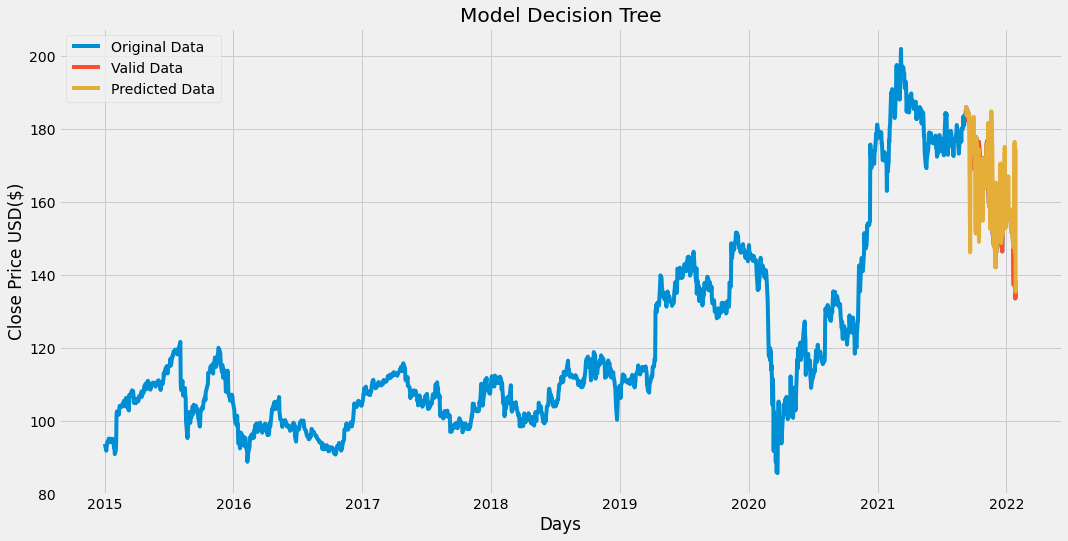

drawing
modelo 4: Model Decision tree
drawing


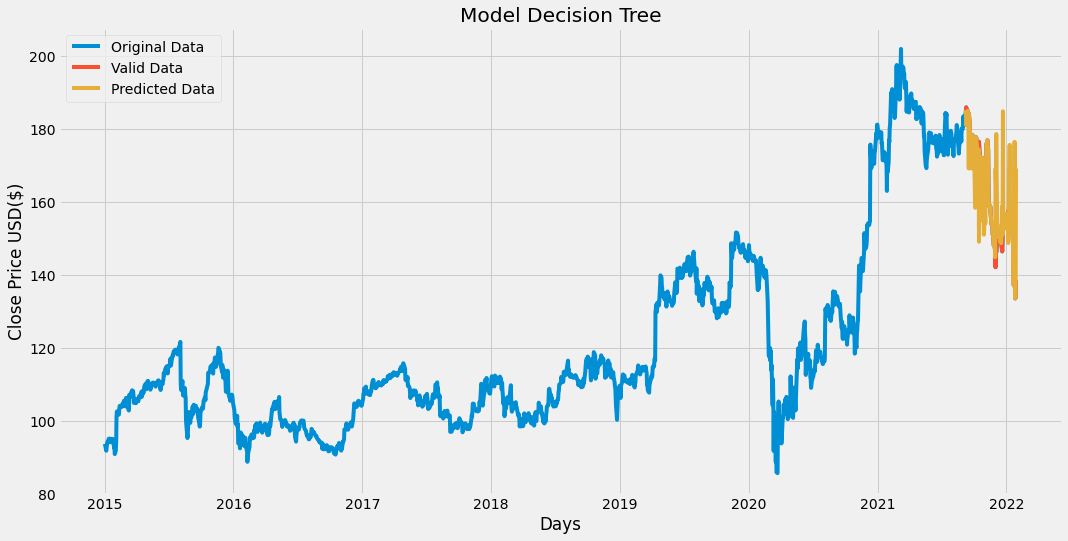

drawing
modelo 4: Model Decision tree
drawing


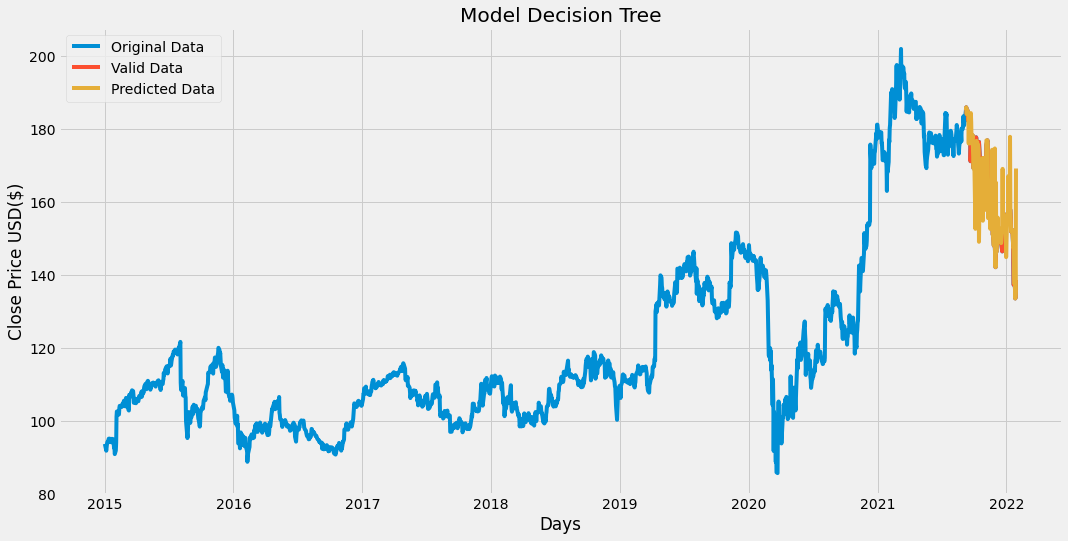

modelo 7: Model Support Vector Regression
drawing


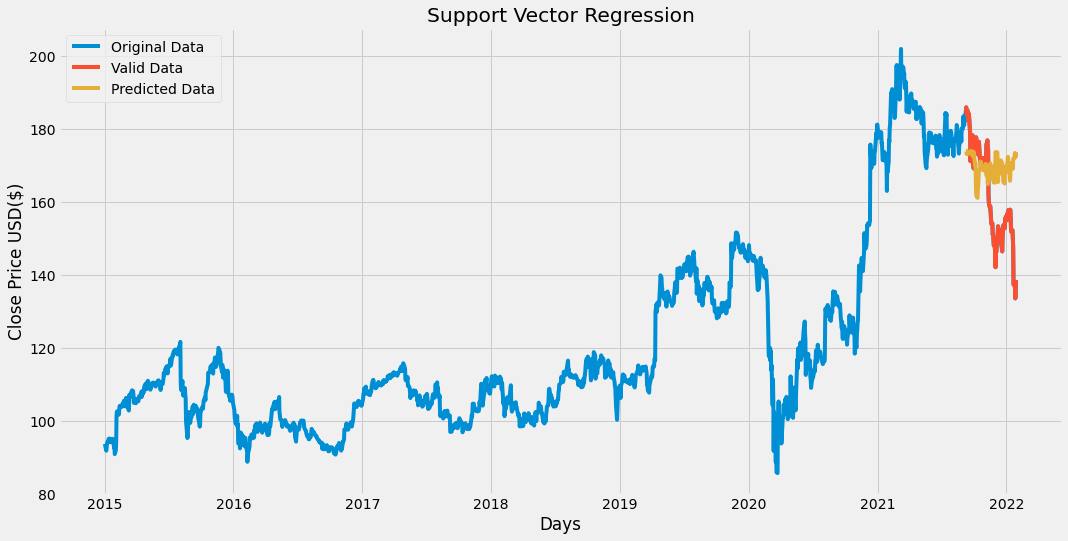

drawing
modelo 4: Model Decision tree
drawing


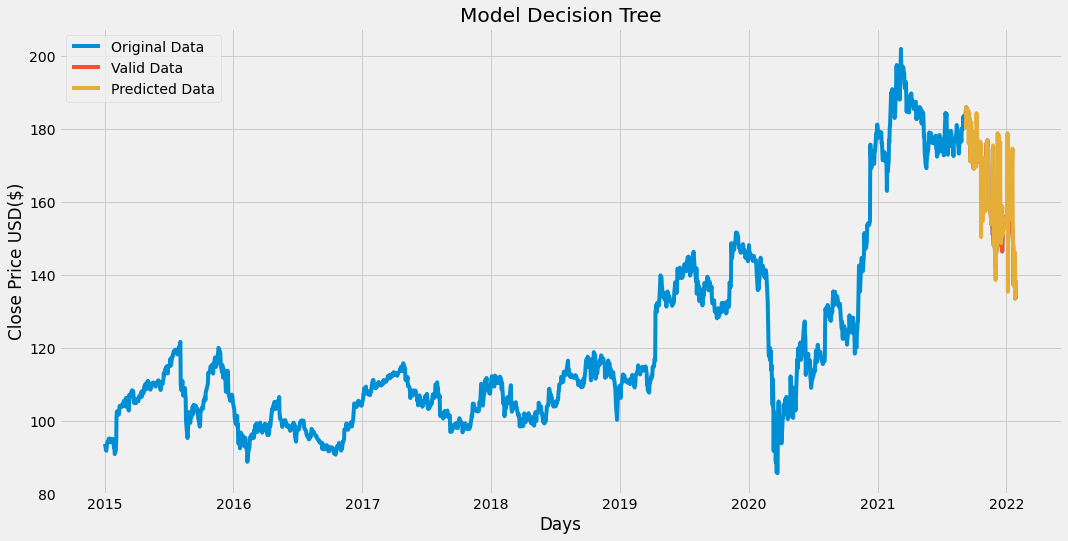

drawing
modelo 4: Model Decision tree
drawing


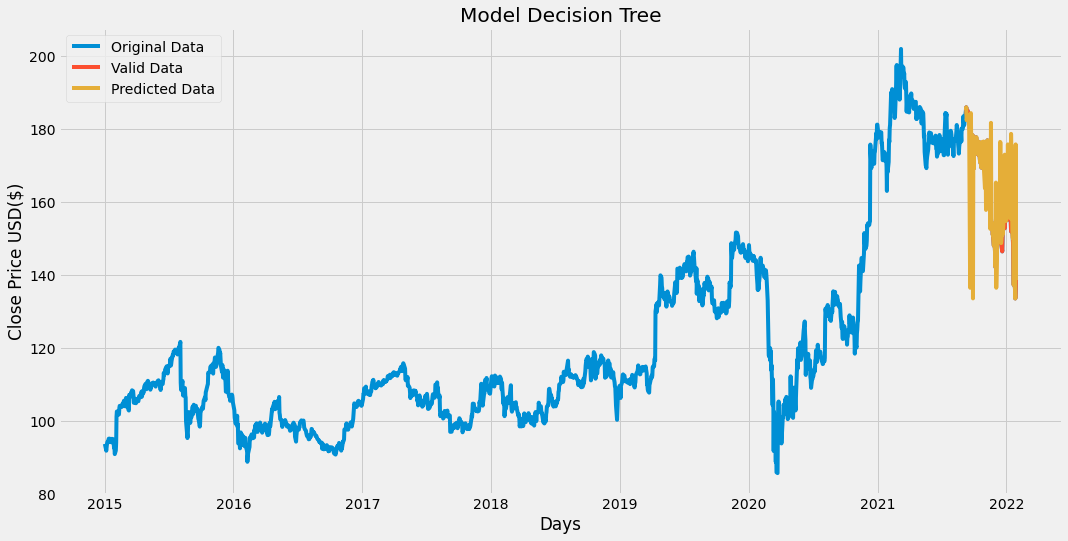

modelo 7: Model Support Vector Regression
drawing


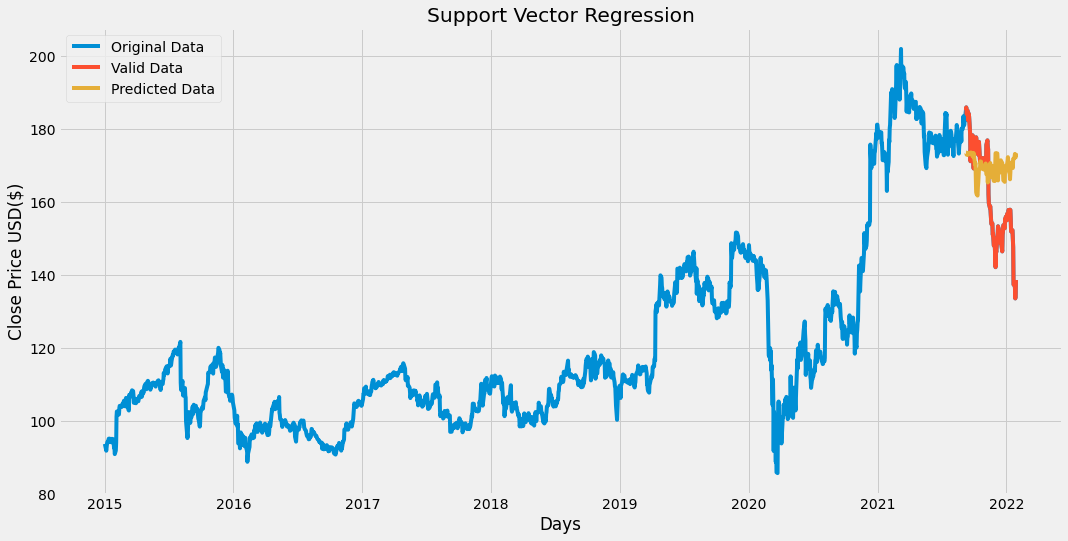

drawing
modelo 4: Model Decision tree
drawing


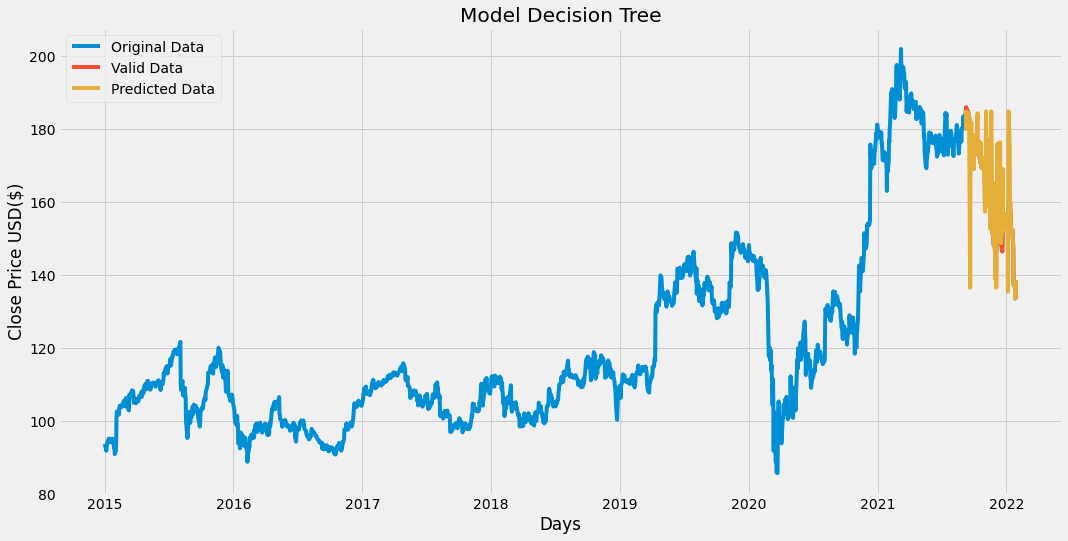

modelo 2: Model ARIMA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=6.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=7521.306, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7069.486, Time=0.58 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.62 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=7494.135, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=6857.248, Time=1.00 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.80 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.94 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=6890.127, Time=0.76 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=6859.121, Time=1.28 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=6859.146, Time=1.78 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=6858.774, Time=1.04 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=6857.842, Time=5.51 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=6859.239, Time=6.41 sec

Best model:  ARI

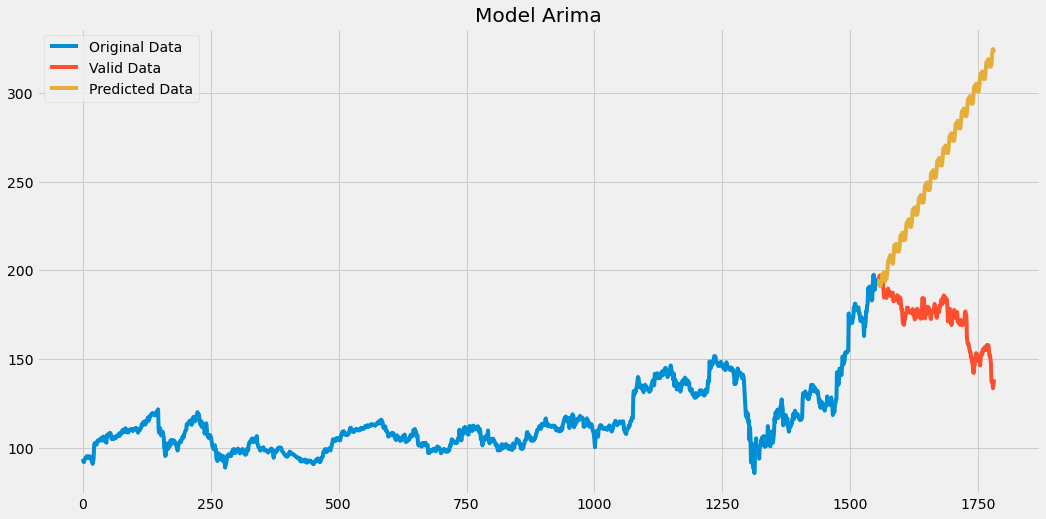

modelo 3: Model LSTM
1491/1491 - 34s - loss: 0.0020 - 34s/epoch - 23ms/step
drawing


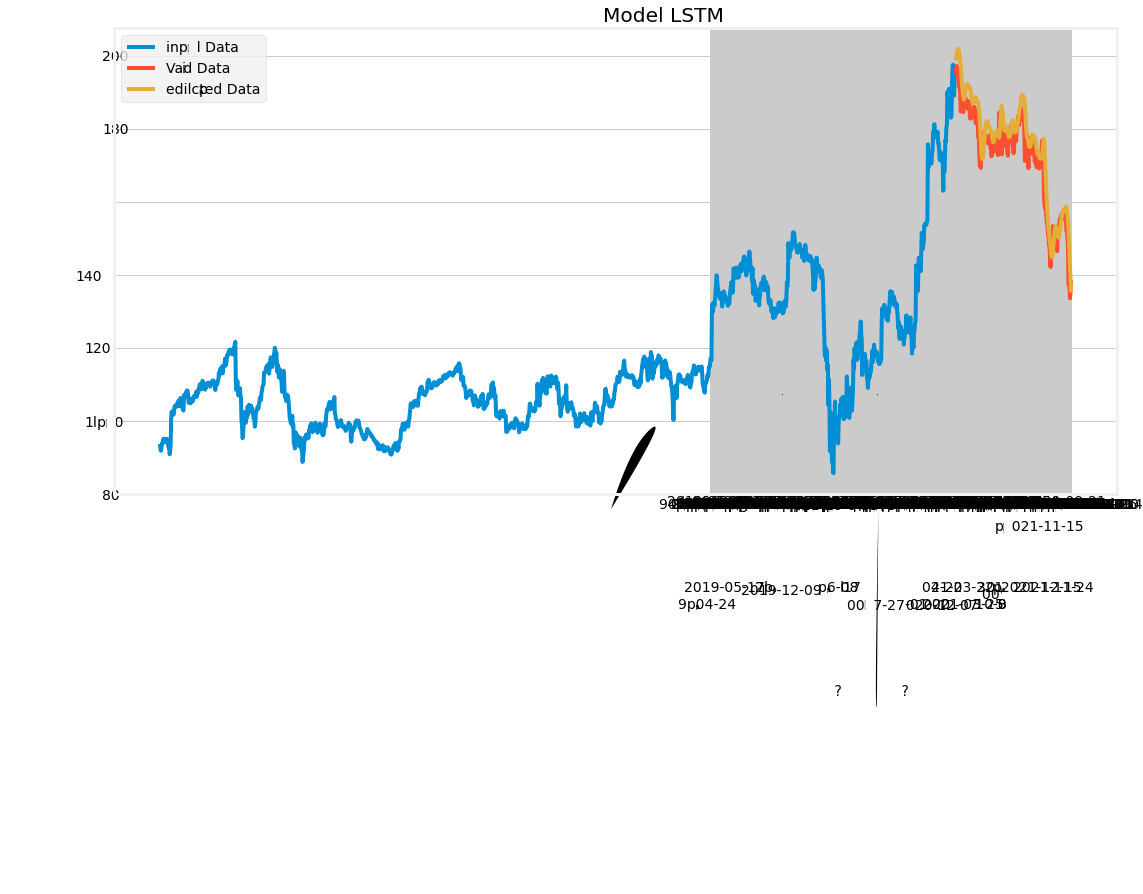

drawing
modelo 4: Model Decision tree
drawing


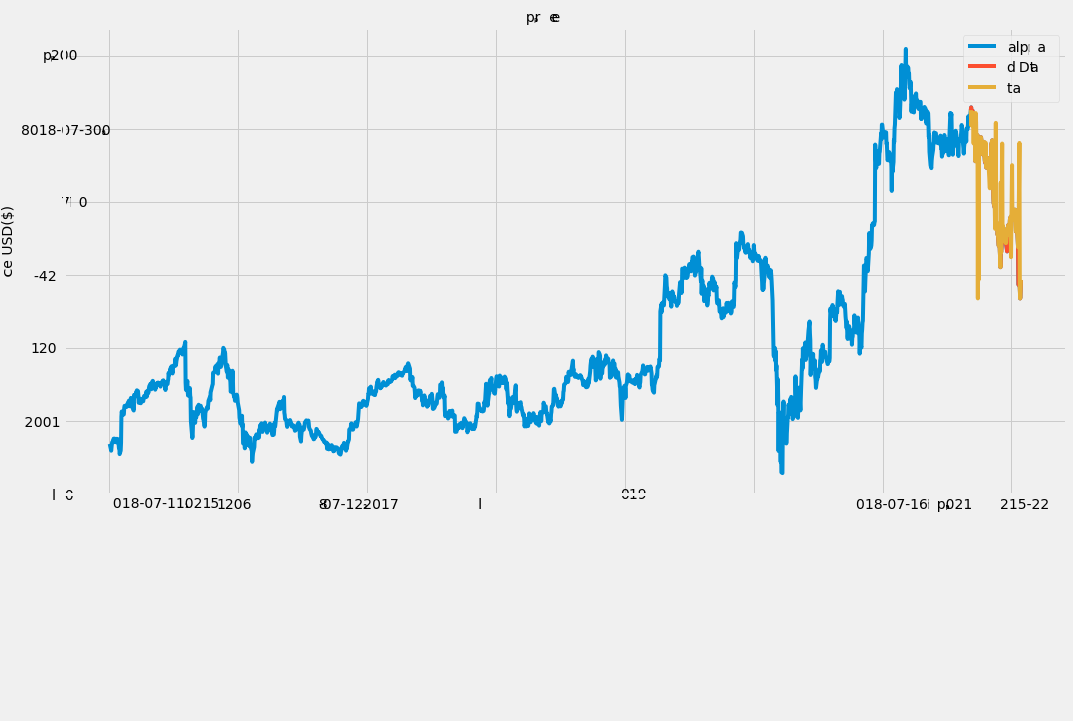

drawing
modelo 4: Model Decision tree
drawing


RuntimeError: In set_text: Could not load glyph (error code 0x14)

<Figure size 1152x576 with 1 Axes>

drawing
modelo 4: Model Decision tree
drawing


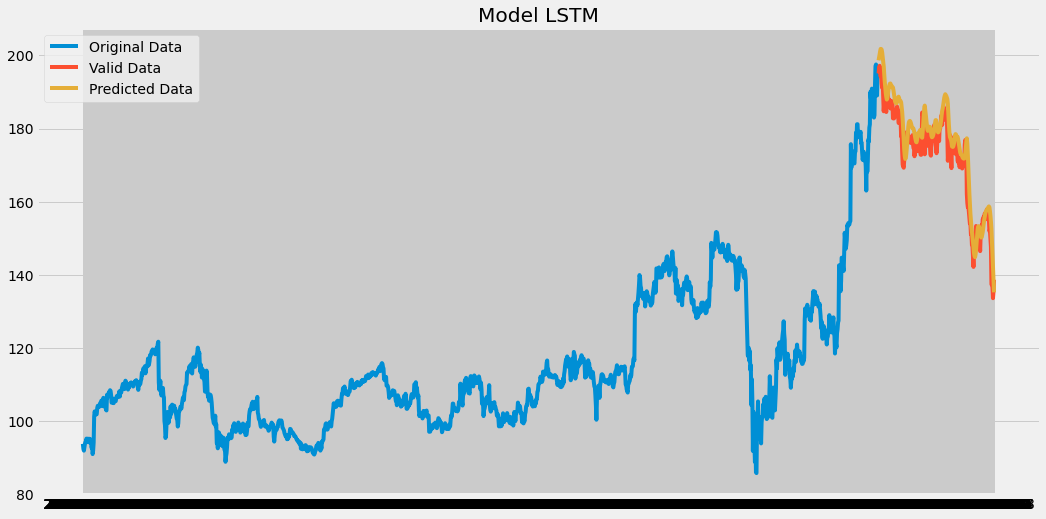

modelo 5: Model Linear Regression
drawing


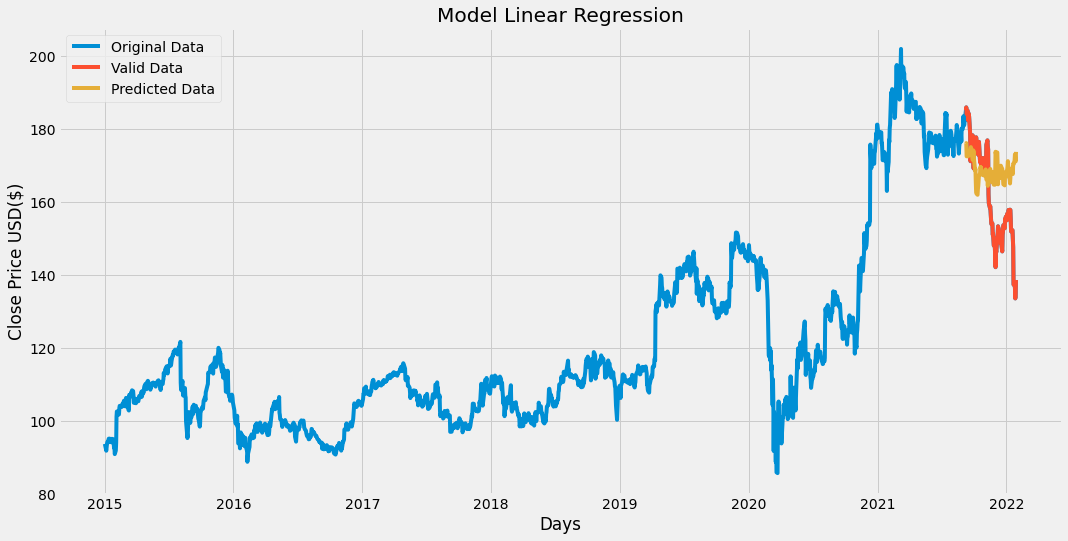

modelo 2: Model ARIMA
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=6.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=7521.306, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7069.486, Time=0.57 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.81 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=7494.135, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=6857.248, Time=1.09 sec
modelo 7: Model Support Vector Regression
drawing
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.25 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.32 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=6890.127, Time=0.84 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=6859.121, Time=1.49 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=6859.146, Time=1.91 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=6858.774, Time=1.12 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=6857.842, Time=6.04 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept

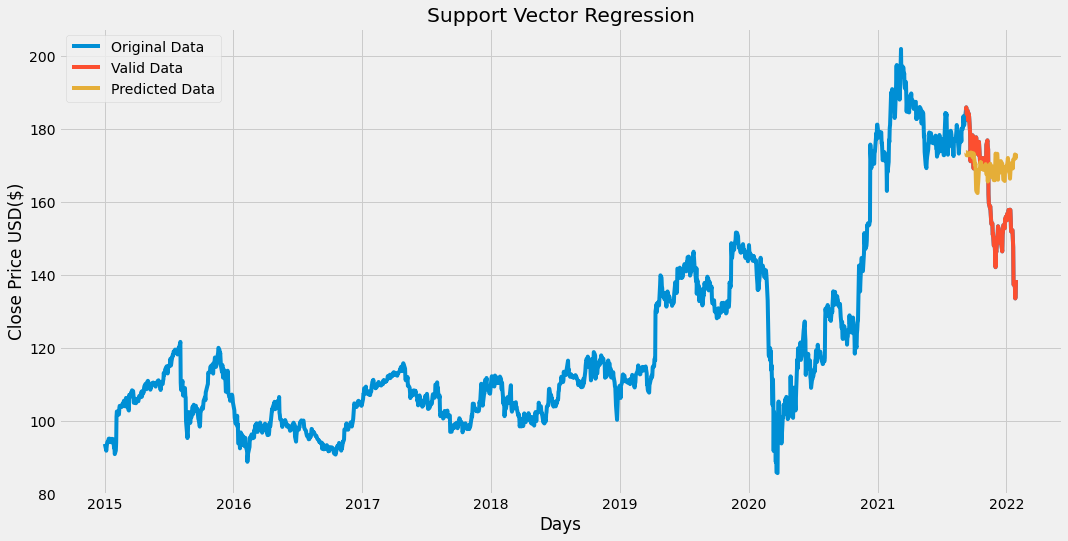

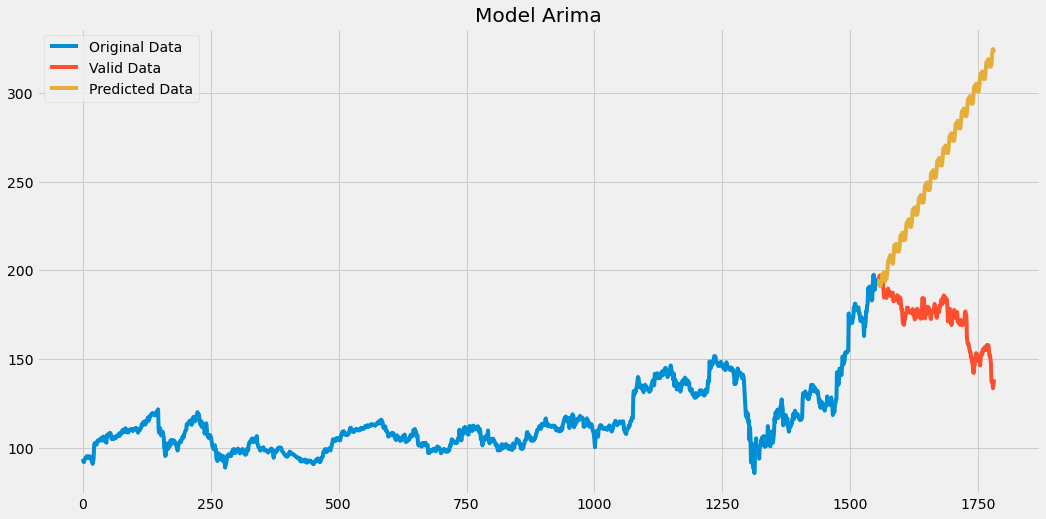

drawing
modelo 4: Model Decision tree
drawing


In [2]:
#servidor libreria
import anvil.server
import anvil.mpl_util
anvil.server.connect("ZHF7ZG5F3UH3SVK6JM6NYZWE-VMH3JYN4CHPFGLTA")
@anvil.server.callable
def make_plot_controller(model):
    plt.show()
    if(model == 1):
        print('modelo 1: Model RMS')
        plt.show()
        make_plot1()
        print('drawing')
        return anvil.mpl_util.plot_image()
    elif (model == 2):
        plt.show()
        print('modelo 2: Model ARIMA')
        make_plot2()
        print('drawing')
        return anvil.mpl_util.plot_image()
    elif (model == 3):
        plt.show()
        print('modelo 3: Model LSTM')
        make_plot3()
        print('drawing')
        return anvil.mpl_util.plot_image()
    elif (model == 4):
        print('drawing')
        print('modelo 4: Model Decision tree')
        make_plot4()
        print('drawing')
        return anvil.mpl_util.plot_image()
    elif (model == 5):
        print('modelo 5: Model Linear Regression')
        make_plot5()
        print('drawing')
        return anvil.mpl_util.plot_image()
    elif (model == 6):
        print('modelo 6: Model Support Vector Classifier')
        make_plot6()
        print('drawing')
        return anvil.mpl_util.plot_image()
    elif (model == 7):
        print('modelo 7: Model Support Vector Regression')
        make_plot7()
        print('drawing')
        return anvil.mpl_util.plot_image()
    elif (model == 8):
        print('modelo 8: Model Random Forest Regressor')
        make_plot8()
        print('drawing')
        return anvil.mpl_util.plot_image()
    elif (model == 9):
        plt.show()
        print('modelo 9: Prophet')
        make_plot8()
        print('drawing')
        return anvil.mpl_util.plot_image()
    else:
        print('no hay modelo')
        return anvil.mpl_util.plot_image()
    #plt.show()
    
        

In [13]:
plt.show()

modelo 6: Model Support Vector Classifier
              precision    recall  f1-score   support

           0       0.55      0.34      0.42       218
           1       0.54      0.73      0.62       228

    accuracy                           0.54       446
   macro avg       0.54      0.54      0.52       446
weighted avg       0.54      0.54      0.52       446

drawing
